# 0. Introduction

In this notebook we will compare out of sample accuracy score for predicting positive returns to different forex instruments at the daily level.

In [1]:
# If you'd like to install packages that are not installed by default, uncomment the last two lines of this cell and replace  with a list of your packages.
# This will ensure your notebook has all the dependencies and works everywhere
# import sys
# !{sys.executable} -m pip install matplotlib numpy pandas pandas_ta seaborn scipy sklearn xgboost yfinance

In [327]:
# import libraries
import timeit
#
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
import yfinance as yf
#
from datetime import datetime
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier , GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier 
from xgboost import XGBClassifier
# https://medium.com/geekculture/xgboost-versus-random-forest-898e42870f30

In [328]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# 1. Dataset construction

To keep things simple, we use 6 Technical Indicators (with multiple parameters) and construct the target label as a 1-day return (Up or Down).

In [329]:
#Function to generate the dataset
def dataset(ticker, days):
    # Define time to download data
    today = datetime.today()
    initial = today - dt.timedelta(days=days)
    today = today.strftime('%Y-%m-%d')
    initial = initial.strftime('%Y-%m-%d')
    #Download data with YFINANCE
    data = yf.download(ticker, start=initial, end=today, progress=False)
    # list with parameter values to use with the Technical Indcators:
    periods = range(14,50)
    # dataframe creation with the Technical Indicators
    df = pd.DataFrame(data[['High', 'Low', 'Close']])
    for n in periods:
        #CCI - Commodity Channel Index
        df.ta.cci(length=n, append=True)
        #RSI - Relative Strength Index
        df.ta.rsi(length=n, append=True)
        #STOCH - Stochastic
        df.ta.stoch(k=n, append=True)
        #WILLR - Williams' %R
        df.ta.willr(length=n, append=True)
        #ADX
        df.ta.adx(length=n, append=True)
        #MACD - Moving Average Convergence/Divergence
        df.ta.macd(slow=n, append=True)
    df.index = data.index
    # 1-day return
    df["Return"] = df["Close"].pct_change().shift(-1)
    # Target variable label
    df["Label"] = np.where(df["Return"]>0,"UP","DOWN")
    # drop nan values
    df = df.dropna()
    df = df.drop(columns=['High', 'Low'])
    return df

# 2. Out-of-sample (OOS) & In-sample (IS) datasets

We assume that 1 year corresponds with 250 observations.

We keep the last year as an out of sample period (OOS) and we define multiple in sample periods (IS).

In this example we use EURUSD as an instrument, which suffer less from a bullish bias like other instruments that pertain to the stock market, for example. We will also repeat the entire exercise for USDJPY and EURGBP instruments.

In [330]:
instrument = "EURUSD=X"
data = dataset(instrument, 4000)
data

,Close,CCI_14_0.015,RSI_14,STOCHk_14_3_3,STOCHd_14_3_3,WILLR_14,ADX_14,DMP_14,DMN_14,MACD_12_14_9,...,STOCHd_49_3_3,WILLR_49,ADX_49,DMP_49,DMN_49,MACD_12_49_9,MACDh_12_49_9,MACDs_12_49_9,Return,Label
Date,,,,,,,,,,,,,,,,,,,,,
2012-04-30,1.324152,127.422385,54.603027,83.716661,82.018227,-10.017628,18.507333,16.972865,20.139205,0.000193,...,43.336723,-50.003167,49.141791,15.193253,35.927417,0.001503,0.001205,0.000298,-0.000132,DOWN
2012-05-01,1.323977,115.498837,54.455407,82.281899,82.570236,-14.487005,17.553293,17.215627,19.094806,0.000282,...,45.116149,-50.361327,48.846962,15.269931,35.501021,0.002079,0.001425,0.000654,0.000000,DOWN
2012-05-02,1.323977,50.088132,54.455407,87.002787,84.333783,-14.487005,17.580584,15.895195,22.842737,0.000341,...,47.377939,-50.361327,48.609123,14.999620,36.075613,0.002534,0.001504,0.001030,-0.006968,DOWN
2012-05-03,1.314752,-42.210902,46.740018,74.685202,81.323296,-46.970384,17.932175,14.398291,22.756219,0.000189,...,46.512672,-69.217312,48.398862,14.666041,35.760893,0.001837,0.000646,0.001192,0.000658,UP
2012-05-04,1.315616,-66.239328,47.491090,60.682191,74.123393,-56.496037,18.399522,13.520184,22.278465,0.000090,...,43.589546,-67.449663,48.204917,14.455871,35.462271,0.001359,0.000134,0.001225,-0.014125,DOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-18,1.036173,85.819574,67.410973,86.033421,85.577773,-15.284101,25.304350,26.385322,9.847386,0.002756,...,88.536146,-12.161970,14.541093,20.520709,15.585239,0.017970,0.008588,0.009382,-0.002975,DOWN
2022-11-21,1.033090,54.709338,65.119551,84.825723,84.997108,-19.426472,25.407215,24.611691,14.225020,0.002673,...,88.061795,-15.458166,14.424605,20.090752,16.829510,0.018830,0.007558,0.011272,-0.008248,DOWN
2022-11-22,1.024569,35.254031,59.136547,78.138112,82.999085,-30.875092,25.502733,23.506028,13.585971,0.002382,...,86.471915,-24.568141,14.310495,19.815362,16.598823,0.018442,0.005737,0.012706,0.006383,UP


In [331]:
# OOS period
oos = data.tail(250)

#IS period, remove oos data
in_sample = data.drop(oos.index)

#1-year IS
is_1A = in_sample.tail(250)

#2-year IS
is_2A = in_sample.tail(500)

#3-year IS
is_3A = in_sample.tail(750)

#4-year IS
is_4A = in_sample.tail(1000)

#5-year IS
is_5A = in_sample.tail(1250)

#6-year IS
is_6A = in_sample.tail(1500)

#7-year IS
is_7A = in_sample.tail(1750)

#8-year IS
is_8A = in_sample.tail(2000)

#9-year IS
is_9A = in_sample.tail(2250)

#10-year IS
is_10A = in_sample.tail(2500)

#11-year IS
is_11A = in_sample.tail(2750)

#12-year IS
is_12A = in_sample.tail(3000)

# 3. Function to generate the OOS accuracy Score for all different models

In [332]:
def score(model, in_sample, out_of_sample):
  if model == "Decision Tree":
    model = DecisionTreeClassifier()
  if model == "Random Forest":
    model = RandomForestClassifier()
  if model == "SVM":
    model = svm.SVC()
  if model == "KNN":
    model = KNeighborsClassifier()
  if model == "XGBoost":
    model = XGBClassifier()
  if model == "AdaBoost":
    model = AdaBoostClassifier()
  if model == "Gaussian Naive Bayes":
    model = GaussianNB()
  if model == "Bernoulli Naive Bayes":
    model = BernoulliNB()
    
  le = LabelEncoder()

  #IS independent variables (features)
  X = in_sample.iloc[:,:-3]
  #IS dependent variable (target label)
  Y = in_sample["Label"]
  Y = le.fit_transform(Y)

  #OOS independent variables (features)
  X_oos = oos.iloc[:,:-3]
  #OOS dependent variable (target label)
  Y_oos = oos["Label"]  
  Y_oos = le.fit_transform(Y_oos)

  # store OOS score and timing of the training
  scores = []
  start = timeit.default_timer()
  for n in range(10):
    # training
    
    model.fit(X, Y)
    
    #OOS ACCURACY
    score = accuracy_score(Y_oos, model.predict(X_oos))
    scores.append(score)
  end = timeit.default_timer() - start
  print(f'Time (ss) for training of model {model}: {end}')

  # We return the average score after 10 training iterations
  return round(np.mean(scores),2)

# 4. Function to construct a results table for each model

In [333]:
def table_scores(model, in_samples, oos):
  years_is = []
  accuracy = []
  for years, period in enumerate(in_samples):
    years_is.append(years+1)
    scores = score(model, period, oos)
    accuracy.append(scores)

  df_scores = pd.DataFrame({"years in sample": years_is, "accuracy oos": accuracy})
  df_scores =df_scores.set_index("years in sample")

  return df_scores


# 5. Display results for each model

In [334]:
models = ["Decision Tree", "Random Forest", "SVM", "KNN", "XGBoost", "AdaBoost", "Gaussian Naive Bayes", "Bernouilli Naive Bayes"]
in_samples = [is_1A, is_2A, is_3A, is_4A, is_5A, is_6A, is_7A, is_8A, is_9A, is_10A, is_11A, is_12A]
dect = table_scores("Decision Tree", in_samples, oos)
dect

Time (ss) for training of model DecisionTreeClassifier(): 0.5808584000042174
Time (ss) for training of model DecisionTreeClassifier(): 1.1928126999991946
Time (ss) for training of model DecisionTreeClassifier(): 2.0147311000037007
Time (ss) for training of model DecisionTreeClassifier(): 2.947038300000713
Time (ss) for training of model DecisionTreeClassifier(): 4.031720099999802
Time (ss) for training of model DecisionTreeClassifier(): 5.06274239999766
Time (ss) for training of model DecisionTreeClassifier(): 6.027477899995574
Time (ss) for training of model DecisionTreeClassifier(): 7.533251400003792
Time (ss) for training of model DecisionTreeClassifier(): 8.009489999996731
Time (ss) for training of model DecisionTreeClassifier(): 8.747281099997053
Time (ss) for training of model DecisionTreeClassifier(): 8.993346100003691
Time (ss) for training of model DecisionTreeClassifier(): 9.232790100002603


,accuracy oos
years in sample,
1,0.56
2,0.59
3,0.57
4,0.59
5,0.59
6,0.57
7,0.62
8,0.62
9,0.60


In [335]:
rf = table_scores("Random Forest", in_samples, oos)
rf

Time (ss) for training of model RandomForestClassifier(): 2.4622851999956765
Time (ss) for training of model RandomForestClassifier(): 4.639642599999206
Time (ss) for training of model RandomForestClassifier(): 6.971127900003921
Time (ss) for training of model RandomForestClassifier(): 10.013147900004697
Time (ss) for training of model RandomForestClassifier(): 13.321461200001067
Time (ss) for training of model RandomForestClassifier(): 16.106191800005035
Time (ss) for training of model RandomForestClassifier(): 19.885293599996658
Time (ss) for training of model RandomForestClassifier(): 22.884958199996618
Time (ss) for training of model RandomForestClassifier(): 26.632952699997986
Time (ss) for training of model RandomForestClassifier(): 30.137511299995822
Time (ss) for training of model RandomForestClassifier(): 29.38787360000424
Time (ss) for training of model RandomForestClassifier(): 29.59410249999928


,accuracy oos
years in sample,
1,0.65
2,0.66
3,0.66
4,0.66
5,0.65
6,0.66
7,0.67
8,0.71
9,0.70


In [336]:
svmach = table_scores("SVM", in_samples, oos)
svmach

Time (ss) for training of model SVC(): 0.29101420000370126
Time (ss) for training of model SVC(): 0.6657914000024903
Time (ss) for training of model SVC(): 1.2227473000020836
Time (ss) for training of model SVC(): 1.8674240000036662
Time (ss) for training of model SVC(): 2.6049943000034546
Time (ss) for training of model SVC(): 3.485758299997542
Time (ss) for training of model SVC(): 4.622259499999927
Time (ss) for training of model SVC(): 5.78564479999477
Time (ss) for training of model SVC(): 7.382036499999231
Time (ss) for training of model SVC(): 9.362450700005866
Time (ss) for training of model SVC(): 8.892600899998797
Time (ss) for training of model SVC(): 9.23871859999781


,accuracy oos
years in sample,
1,0.54
2,0.60
3,0.64
4,0.68
5,0.69
6,0.69
7,0.67
8,0.69
9,0.70


In [337]:
knn = table_scores("KNN", in_samples, oos)
knn

Time (ss) for training of model KNeighborsClassifier(): 0.20404039999993984
Time (ss) for training of model KNeighborsClassifier(): 0.24671089999901596
Time (ss) for training of model KNeighborsClassifier(): 0.2625329000002239
Time (ss) for training of model KNeighborsClassifier(): 0.2813527999969665
Time (ss) for training of model KNeighborsClassifier(): 0.32311900000058813
Time (ss) for training of model KNeighborsClassifier(): 0.3788191999992705
Time (ss) for training of model KNeighborsClassifier(): 0.38595340000028955
Time (ss) for training of model KNeighborsClassifier(): 0.43546559999958845
Time (ss) for training of model KNeighborsClassifier(): 0.5099618000022019
Time (ss) for training of model KNeighborsClassifier(): 0.5129694999995991
Time (ss) for training of model KNeighborsClassifier(): 0.4985175999972853
Time (ss) for training of model KNeighborsClassifier(): 0.5489610000004177


,accuracy oos
years in sample,
1,0.57
2,0.59
3,0.65
4,0.63
5,0.61
6,0.61
7,0.60
8,0.58
9,0.59


In [338]:
xgb = table_scores("XGBoost", in_samples, oos)
xgb

Time (ss) for training of model XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...): 3.778765900002327
Time (ss) for training of model XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
           

Time (ss) for training of model XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...): 66.79741710000235


,accuracy oos
years in sample,
1,0.66
2,0.68
3,0.70
4,0.69
5,0.65
6,0.68
7,0.68
8,0.70
9,0.72


In [339]:
ab = table_scores("AdaBoost", in_samples, oos)
ab

Time (ss) for training of model AdaBoostClassifier(): 4.705236800000421
Time (ss) for training of model AdaBoostClassifier(): 9.076399100005801
Time (ss) for training of model AdaBoostClassifier(): 14.59680230000231
Time (ss) for training of model AdaBoostClassifier(): 19.19646179999836
Time (ss) for training of model AdaBoostClassifier(): 25.325300399999833
Time (ss) for training of model AdaBoostClassifier(): 29.393901800001913
Time (ss) for training of model AdaBoostClassifier(): 34.489716600000975
Time (ss) for training of model AdaBoostClassifier(): 40.41698900000483
Time (ss) for training of model AdaBoostClassifier(): 47.21148920000269
Time (ss) for training of model AdaBoostClassifier(): 51.34358959999372
Time (ss) for training of model AdaBoostClassifier(): 46.78639459999977
Time (ss) for training of model AdaBoostClassifier(): 47.210814799997024


,accuracy oos
years in sample,
1,0.65
2,0.69
3,0.65
4,0.65
5,0.68
6,0.68
7,0.65
8,0.69
9,0.66


In [340]:
gnb = table_scores("Gaussian Naive Bayes", in_samples, oos)
gnb

Time (ss) for training of model GaussianNB(): 0.07259599999815691
Time (ss) for training of model GaussianNB(): 0.08648420000099577
Time (ss) for training of model GaussianNB(): 0.1281693000055384
Time (ss) for training of model GaussianNB(): 0.11750390000088373
Time (ss) for training of model GaussianNB(): 0.13889049999852432
Time (ss) for training of model GaussianNB(): 0.1459026000011363
Time (ss) for training of model GaussianNB(): 0.20171409999602474
Time (ss) for training of model GaussianNB(): 0.2282781000030809
Time (ss) for training of model GaussianNB(): 0.1975423000039882
Time (ss) for training of model GaussianNB(): 0.21179120000306284
Time (ss) for training of model GaussianNB(): 0.20176730000093812
Time (ss) for training of model GaussianNB(): 0.24601450000045588


,accuracy oos
years in sample,
1,0.54
2,0.52
3,0.57
4,0.62
5,0.53
6,0.57
7,0.60
8,0.56
9,0.54


In [341]:
bnb = table_scores("Bernoulli Naive Bayes", in_samples, oos)
bnb

Time (ss) for training of model BernoulliNB(): 0.07288719999633031
Time (ss) for training of model BernoulliNB(): 0.0939963999990141
Time (ss) for training of model BernoulliNB(): 0.12232940000103554
Time (ss) for training of model BernoulliNB(): 0.15509239999664715
Time (ss) for training of model BernoulliNB(): 0.1672134999971604
Time (ss) for training of model BernoulliNB(): 0.14985019999585347
Time (ss) for training of model BernoulliNB(): 0.19454489999770885
Time (ss) for training of model BernoulliNB(): 0.1909142000004067
Time (ss) for training of model BernoulliNB(): 0.1828518999973312
Time (ss) for training of model BernoulliNB(): 0.2696252999958233
Time (ss) for training of model BernoulliNB(): 0.18310319999727653
Time (ss) for training of model BernoulliNB(): 0.28418140000576386


,accuracy oos
years in sample,
1,0.49
2,0.50
3,0.52
4,0.52
5,0.50
6,0.51
7,0.51
8,0.51
9,0.50


# 6. Display results altogether

In [342]:
results = pd.DataFrame()
results.index = dect.index
results["Decision Tree"] = dect["accuracy oos"]
results["Random Forest"] = rf["accuracy oos"]
results["SVM"] = svmach["accuracy oos"]
results["KNN"] = knn["accuracy oos"]
results["XGBoost"] = xgb["accuracy oos"]
results["AdaBoost"] = ab["accuracy oos"]
results["Gaussian Naive Bayes"] = gnb["accuracy oos"]
results["Bernoulli Naive Bayes"] = bnb["accuracy oos"]

results

,Decision Tree,Random Forest,SVM,KNN,XGBoost,AdaBoost,Gaussian Naive Bayes,Bernoulli Naive Bayes
years in sample,,,,,,,,
1,0.56,0.65,0.54,0.57,0.66,0.65,0.54,0.49
2,0.59,0.66,0.60,0.59,0.68,0.69,0.52,0.50
3,0.57,0.66,0.64,0.65,0.70,0.65,0.57,0.52
4,0.59,0.66,0.68,0.63,0.69,0.65,0.62,0.52
5,0.59,0.65,0.69,0.61,0.65,0.68,0.53,0.50
6,0.57,0.66,0.69,0.61,0.68,0.68,0.57,0.51
7,0.62,0.67,0.67,0.60,0.68,0.65,0.60,0.51
8,0.62,0.71,0.69,0.58,0.70,0.69,0.56,0.51
9,0.60,0.70,0.70,0.59,0.72,0.66,0.54,0.50


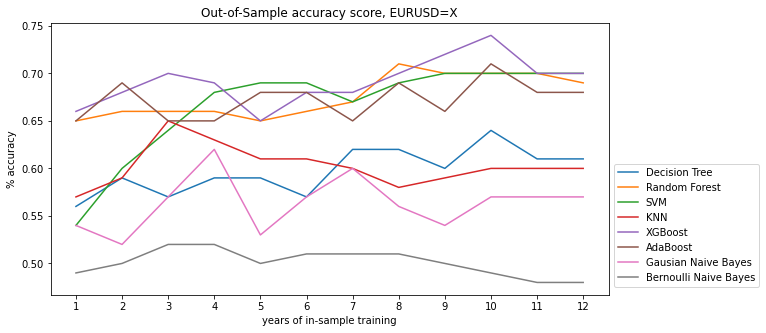

In [343]:
plt.figure(figsize=(10, 5))
plt.plot(results["Decision Tree"], label="Decision Tree")
plt.plot(results["Random Forest"], label="Random Forest")
plt.plot(results["SVM"], label="SVM")
plt.plot(results["KNN"], label="KNN")
plt.plot(results["XGBoost"], label="XGBoost")
plt.plot(results["AdaBoost"], label="AdaBoost")
plt.plot(results["Gaussian Naive Bayes"], label="Gausian Naive Bayes")
plt.plot(results["Bernoulli Naive Bayes"], label="Bernoulli Naive Bayes")
plt.legend(bbox_to_anchor = (1, 0.5))
plt.ylabel('% accuracy')
plt.xlabel('years of in-sample training')
plt.title(f'Out-of-Sample accuracy score, {instrument}')
plt.xticks(np.arange(min(results.index), max(results.index)+1, 1.0))
plt.show()

# 7. Repeat the process for different instruments: USDJPY

In [344]:
instrument = "USDJPY=X"
data = dataset(instrument, 4000)
data

,Close,CCI_14_0.015,RSI_14,STOCHk_14_3_3,STOCHd_14_3_3,WILLR_14,ADX_14,DMP_14,DMN_14,MACD_12_14_9,...,STOCHd_49_3_3,WILLR_49,ADX_49,DMP_49,DMN_49,MACD_12_49_9,MACDh_12_49_9,MACDs_12_49_9,Return,Label
Date,,,,,,,,,,,,,,,,,,,,,
2012-04-30,80.349998,-199.967376,40.189437,47.672309,49.952261,-69.433683,18.232685,14.749267,25.640548,-0.053602,...,38.253286,-85.862709,31.481574,21.350974,19.011120,0.091459,-0.228544,0.320003,-0.005339,DOWN
2012-05-01,79.920998,-189.510329,37.161770,30.787872,43.977207,-86.414586,18.967150,13.833042,24.858782,-0.071921,...,29.110980,-93.564791,30.643009,20.889835,18.882496,-0.053539,-0.298834,0.245294,0.003616,UP
2012-05-02,80.209999,-100.481866,40.418162,23.743080,34.067754,-72.922492,19.044595,15.598846,23.422428,-0.077952,...,19.338028,-87.173785,29.905838,21.355453,18.508427,-0.138091,-0.306708,0.168617,-0.001110,DOWN
2012-05-03,80.121002,-86.701529,39.735276,21.195197,25.242050,-77.077330,19.116490,14.991100,22.509867,-0.082602,...,12.984339,-89.141871,29.199531,21.077741,18.267739,-0.216055,-0.307738,0.091683,0.001111,UP
2012-05-04,80.209999,-88.292653,40.812209,25.692562,23.543613,-72.922492,19.583222,14.217018,24.021910,-0.082491,...,11.114314,-87.173785,28.449392,20.720789,18.835482,-0.267925,-0.287686,0.019761,-0.004887,DOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-18,140.412003,-72.571551,36.290336,15.952971,14.576426,-76.332092,33.766247,7.736673,26.014285,-0.422963,...,11.363133,-81.575605,18.590658,15.670949,21.102217,-1.343086,-1.695016,0.351929,-0.001132,DOWN
2022-11-21,140.253006,-50.943525,35.880339,20.127895,17.037173,-76.997645,33.733828,12.255088,24.498628,-0.413358,...,13.218028,-82.701006,18.407869,17.049199,20.684452,-1.549045,-1.520779,-0.028265,0.013155,UP
2022-11-22,142.098007,-24.786408,43.812999,29.012445,21.697771,-59.632927,33.509823,12.182652,22.924723,-0.359988,...,16.647790,-69.641816,18.214313,16.921084,20.236941,-1.496767,-1.174801,-0.321966,-0.006636,DOWN


In [345]:
# OOS period
oos = data.tail(250)

#IS period, remove oos data
in_sample = data.drop(oos.index)

#1-year IS
is_1A = in_sample.tail(250)

#2-year IS
is_2A = in_sample.tail(500)

#3-year IS
is_3A = in_sample.tail(750)

#4-year IS
is_4A = in_sample.tail(1000)

#5-year IS
is_5A = in_sample.tail(1250)

#6-year IS
is_6A = in_sample.tail(1500)

#7-year IS
is_7A = in_sample.tail(1750)

#8-year IS
is_8A = in_sample.tail(2000)

#9-year IS
is_9A = in_sample.tail(2250)

#10-year IS
is_10A = in_sample.tail(2500)

#11-year IS
is_11A = in_sample.tail(2750)

#12-year IS
is_12A = in_sample.tail(3000)

in_samples = [is_1A, is_2A, is_3A, is_4A, is_5A, is_6A, is_7A, is_8A, is_9A, is_10A, is_11A, is_12A]

In [346]:
dect = table_scores("Decision Tree", in_samples, oos)
rf = table_scores("Random Forest", in_samples, oos)
svmach = table_scores("SVM", in_samples, oos)
knn = table_scores("KNN", in_samples, oos)
xgb = table_scores("XGBoost", in_samples, oos)
ab = table_scores("AdaBoost", in_samples, oos)
gnb = table_scores("Gaussian Naive Bayes", in_samples, oos)
bnb = table_scores("Bernoulli Naive Bayes", in_samples, oos)

Time (ss) for training of model DecisionTreeClassifier(): 0.4541164999973262
Time (ss) for training of model DecisionTreeClassifier(): 1.1567723999978625
Time (ss) for training of model DecisionTreeClassifier(): 1.9800599000009242
Time (ss) for training of model DecisionTreeClassifier(): 2.604866599998786
Time (ss) for training of model DecisionTreeClassifier(): 3.762713600001007
Time (ss) for training of model DecisionTreeClassifier(): 4.608505799995328
Time (ss) for training of model DecisionTreeClassifier(): 5.428842300003453
Time (ss) for training of model DecisionTreeClassifier(): 6.2944652999940445
Time (ss) for training of model DecisionTreeClassifier(): 7.059073099997477
Time (ss) for training of model DecisionTreeClassifier(): 7.92171199999575
Time (ss) for training of model DecisionTreeClassifier(): 8.122964300004242
Time (ss) for training of model DecisionTreeClassifier(): 8.162407499999972
Time (ss) for training of model RandomForestClassifier(): 2.062490500000422
Time (ss)

Time (ss) for training of model XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...): 51.03953779999574
Time (ss) for training of model XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
           

In [347]:
results = pd.DataFrame()
results.index = dect.index
results["Decision Tree"] = dect["accuracy oos"]
results["Random Forest"] = rf["accuracy oos"]
results["SVM"] = svmach["accuracy oos"]
results["KNN"] = knn["accuracy oos"]
results["XGBoost"] = xgb["accuracy oos"]
results["AdaBoost"] = ab["accuracy oos"]
results["Gaussian Naive Bayes"] = gnb["accuracy oos"]
results["Bernoulli Naive Bayes"] = bnb["accuracy oos"]

results

,Decision Tree,Random Forest,SVM,KNN,XGBoost,AdaBoost,Gaussian Naive Bayes,Bernoulli Naive Bayes
years in sample,,,,,,,,
1,0.60,0.62,0.60,0.52,0.69,0.61,0.47,0.47
2,0.62,0.60,0.62,0.54,0.66,0.60,0.48,0.48
3,0.60,0.61,0.58,0.55,0.64,0.62,0.47,0.48
4,0.58,0.62,0.61,0.54,0.64,0.61,0.50,0.47
5,0.55,0.62,0.62,0.55,0.63,0.62,0.50,0.46
6,0.60,0.64,0.62,0.52,0.67,0.61,0.46,0.45
7,0.55,0.62,0.61,0.53,0.68,0.62,0.50,0.44
8,0.60,0.62,0.62,0.56,0.71,0.64,0.52,0.46
9,0.59,0.62,0.66,0.54,0.72,0.63,0.52,0.45


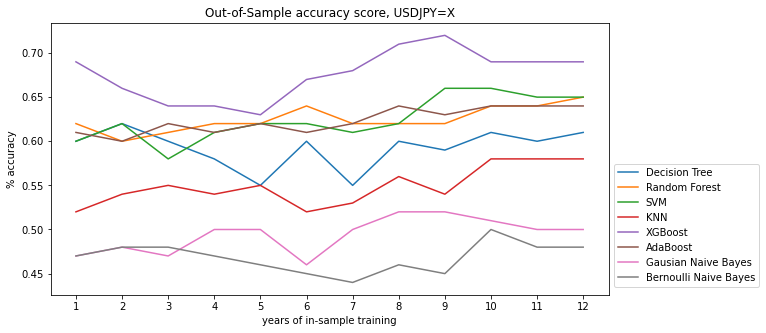

In [348]:
plt.figure(figsize=(10, 5))
plt.plot(results["Decision Tree"], label="Decision Tree")
plt.plot(results["Random Forest"], label="Random Forest")
plt.plot(results["SVM"], label="SVM")
plt.plot(results["KNN"], label="KNN")
plt.plot(results["XGBoost"], label="XGBoost")
plt.plot(results["AdaBoost"], label="AdaBoost")
plt.plot(results["Gaussian Naive Bayes"], label="Gausian Naive Bayes")
plt.plot(results["Bernoulli Naive Bayes"], label="Bernoulli Naive Bayes")
plt.legend(bbox_to_anchor = (1, 0.5))
plt.ylabel('% accuracy')
plt.xlabel('years of in-sample training')
plt.title(f'Out-of-Sample accuracy score, {instrument}')
plt.xticks(np.arange(min(results.index), max(results.index)+1, 1.0))
plt.show()

# 8. Repeat the process for different instruments: EURGBP

In [349]:
instrument = "EURGBP=X"
data = dataset(instrument, 4000)
data

,Close,CCI_14_0.015,RSI_14,STOCHk_14_3_3,STOCHd_14_3_3,WILLR_14,ADX_14,DMP_14,DMN_14,MACD_12_14_9,...,STOCHd_49_3_3,WILLR_49,ADX_49,DMP_49,DMN_49,MACD_12_49_9,MACDh_12_49_9,MACDs_12_49_9,Return,Label
Date,,,,,,,,,,,,,,,,,,,,,
2012-04-30,0.81310,-118.860087,28.432883,15.399020,18.798543,-93.793291,24.371271,12.165554,25.324668,-0.000790,...,6.937358,-97.645905,8.313475,14.991719,21.229874,-0.008501,-0.001423,-0.007078,0.002952,UP
2012-05-01,0.81550,-54.499692,34.758836,14.146917,16.817291,-77.241243,23.627723,17.247136,22.853498,-0.000755,...,6.267892,-91.368007,8.410814,16.405951,20.620252,-0.008553,-0.001180,-0.007373,0.000613,UP
2012-05-02,0.81600,-95.469448,36.027396,19.977688,16.507875,-69.032402,23.707200,16.046332,26.595212,-0.000704,...,6.278993,-87.764559,8.619080,16.070484,21.764831,-0.008486,-0.000890,-0.007596,-0.005147,DOWN
2012-05-03,0.81180,-139.991973,30.637966,21.277964,18.467523,-89.892463,23.975165,14.687350,25.803091,-0.000738,...,7.148826,-95.866631,8.849207,15.666915,21.651256,-0.008857,-0.001009,-0.007848,0.000616,UP
2012-05-04,0.81230,-121.112064,31.943261,18.113790,19.789814,-86.733764,24.223930,13.962791,24.530169,-0.000738,...,7.779581,-94.574915,9.069852,15.441690,21.340001,-0.009048,-0.000960,-0.008088,-0.009922,DOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-18,0.87333,0.007693,50.694357,60.638851,66.588009,-36.984014,23.737392,16.867856,10.933940,0.000157,...,25.067357,-75.689126,21.341532,19.597170,12.246114,0.001932,0.000527,0.001405,-0.004866,DOWN
2022-11-21,0.86908,-75.278536,48.067972,56.134230,61.423026,-54.886252,23.036338,15.963926,12.061981,0.000063,...,23.310071,-82.090679,21.338680,19.298613,12.546812,0.001449,0.000035,0.001414,-0.003348,DOWN
2022-11-22,0.86617,-150.673258,46.299227,44.605757,53.792946,-74.312462,21.823290,15.270557,13.527233,-0.000067,...,21.059058,-86.473898,21.293113,19.065330,12.948749,0.000717,-0.000558,0.001275,0.000739,UP


In [350]:
# OOS period
oos = data.tail(250)

#IS period, remove oos data
in_sample = data.drop(oos.index)

#1-year IS
is_1A = in_sample.tail(250)

#2-year IS
is_2A = in_sample.tail(500)

#3-year IS
is_3A = in_sample.tail(750)

#4-year IS
is_4A = in_sample.tail(1000)

#5-year IS
is_5A = in_sample.tail(1250)

#6-year IS
is_6A = in_sample.tail(1500)

#7-year IS
is_7A = in_sample.tail(1750)

#8-year IS
is_8A = in_sample.tail(2000)

#9-year IS
is_9A = in_sample.tail(2250)

#10-year IS
is_10A = in_sample.tail(2500)

#11-year IS
is_11A = in_sample.tail(2750)

#12-year IS
is_12A = in_sample.tail(3000)

in_samples = [is_1A, is_2A, is_3A, is_4A, is_5A, is_6A, is_7A, is_8A, is_9A, is_10A, is_11A, is_12A]

In [351]:
dect = table_scores("Decision Tree", in_samples, oos)
rf = table_scores("Random Forest", in_samples, oos)
svmach = table_scores("SVM", in_samples, oos)
knn = table_scores("KNN", in_samples, oos)
xgb = table_scores("XGBoost", in_samples, oos)
ab = table_scores("AdaBoost", in_samples, oos)
gnb = table_scores("Gaussian Naive Bayes", in_samples, oos)
bnb = table_scores("Bernoulli Naive Bayes", in_samples, oos)

Time (ss) for training of model DecisionTreeClassifier(): 0.4334392000018852
Time (ss) for training of model DecisionTreeClassifier(): 1.1412411999990582
Time (ss) for training of model DecisionTreeClassifier(): 1.8166595000002417
Time (ss) for training of model DecisionTreeClassifier(): 2.5878185000037774
Time (ss) for training of model DecisionTreeClassifier(): 3.628883199999109
Time (ss) for training of model DecisionTreeClassifier(): 4.3119493999984115
Time (ss) for training of model DecisionTreeClassifier(): 4.922873900002742
Time (ss) for training of model DecisionTreeClassifier(): 6.4655224999951315
Time (ss) for training of model DecisionTreeClassifier(): 7.189392100000987
Time (ss) for training of model DecisionTreeClassifier(): 8.153354900001432
Time (ss) for training of model DecisionTreeClassifier(): 7.955419599995366
Time (ss) for training of model DecisionTreeClassifier(): 7.917247299999872
Time (ss) for training of model RandomForestClassifier(): 2.1756707999957143
Time 

Time (ss) for training of model XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...): 47.541392600003746
Time (ss) for training of model XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
          

In [352]:
results = pd.DataFrame()
results.index = dect.index
results["Decision Tree"] = dect["accuracy oos"]
results["Random Forest"] = rf["accuracy oos"]
results["SVM"] = svmach["accuracy oos"]
results["KNN"] = knn["accuracy oos"]
results["XGBoost"] = xgb["accuracy oos"]
results["AdaBoost"] = ab["accuracy oos"]
results["Gaussian Naive Bayes"] = gnb["accuracy oos"]
results["Bernoulli Naive Bayes"] = bnb["accuracy oos"]

results

,Decision Tree,Random Forest,SVM,KNN,XGBoost,AdaBoost,Gaussian Naive Bayes,Bernoulli Naive Bayes
years in sample,,,,,,,,
1,0.59,0.60,0.59,0.58,0.64,0.64,0.55,0.52
2,0.66,0.66,0.65,0.58,0.66,0.62,0.53,0.56
3,0.61,0.67,0.65,0.55,0.63,0.63,0.55,0.52
4,0.63,0.61,0.65,0.59,0.62,0.58,0.53,0.54
5,0.61,0.64,0.67,0.54,0.64,0.59,0.58,0.51
6,0.57,0.65,0.68,0.52,0.67,0.61,0.58,0.50
7,0.65,0.64,0.70,0.54,0.66,0.62,0.59,0.51
8,0.63,0.66,0.70,0.56,0.68,0.66,0.60,0.57
9,0.63,0.69,0.71,0.57,0.72,0.68,0.58,0.55


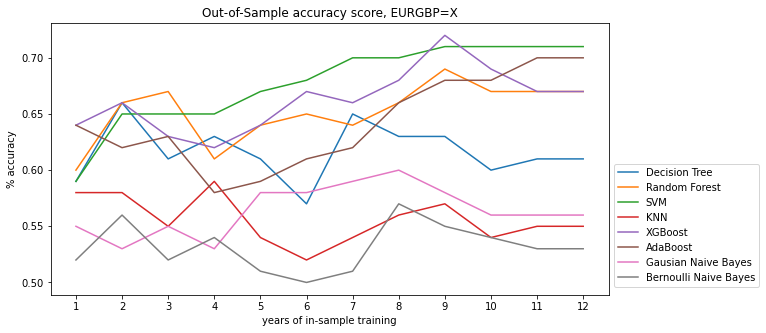

In [353]:
plt.figure(figsize=(10, 5))
plt.plot(results["Decision Tree"], label="Decision Tree")
plt.plot(results["Random Forest"], label="Random Forest")
plt.plot(results["SVM"], label="SVM")
plt.plot(results["KNN"], label="KNN")
plt.plot(results["XGBoost"], label="XGBoost")
plt.plot(results["AdaBoost"], label="AdaBoost")
plt.plot(results["Gaussian Naive Bayes"], label="Gausian Naive Bayes")
plt.plot(results["Bernoulli Naive Bayes"], label="Bernoulli Naive Bayes")
plt.legend(bbox_to_anchor = (1, 0.5))
plt.ylabel('% accuracy')
plt.xlabel('years of in-sample training')
plt.title(f'Out-of-Sample accuracy score, {instrument}')
plt.xticks(np.arange(min(results.index), max(results.index)+1, 1.0))
plt.show()